In [1]:
import Ramsey_ExperimentV3
import estimator
import numpy as np

In [31]:
from importlib import reload

reload(Ramsey_ExperimentV3)

<module 'Ramsey_ExperimentV3' from 'C:\\Projects\\Crosstalk\\Ramsey_ExperimentV3.py'>

In [34]:
from tqdm import tqdm
import random

T = np.pi
uni_delay = np.linspace(0, T, 20)
# shots = np.arange(500, 20000, 2000)
shots = 5000
errors_fisher = []
errors_local = []
uniform_local = []
uniform_local_G = []
uniform_local_X = []
N = [1, 2, 3, 4, 5]
delay = [1.5]
fisher_delay = [0.4439410861020235, 1.784695781691183]  #todo change for a better average

repetitions = 50

for rep in tqdm(range(repetitions)):
    rep_error_fisher = []
    rep_error_local = []
    rep_error_uniform = []
    rep_error_uniform_G = []
    rep_error_uniform_X = []

    W = [random.gauss(1, 0.2) for _ in range(N[-1])]
    Decay = [random.gauss(1, 0.2) for _ in range(N[-1])]
    J = {}
    J_list = [random.gauss(0.5, 0.1) for _ in range(N[-1] - 1)]
    for i in range(N[-1] - 1):  # Only connect to the next neighbor
        J[(i, i + 1)] = J_list[i]

    for n in N:
        J_subset = {key: J[key] for key in list(J.keys())[:(n - 1)]}

        # batch_x, batch_y = Ramsey_ExperimentV2.ramsey_global(n, s, delay, Decay, W, J)
        batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = Ramsey_ExperimentV3.simulate_circuit(n, shots, delay,
                                                                                                  Decay[:n],
                                                                                                  W[:n], J_subset, "XY")
        # batch_x_det_uni, batch_cross_uni = Ramsey_ExperimentV3.ramsey_local_X(n, s, uni_delay, Decay, W, J)
        batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni, batch_y_cross_uni = Ramsey_ExperimentV3.simulate_circuit(n,
                                                                                                                  shots,
                                                                                                                  uni_delay,
                                                                                                                  Decay[
                                                                                                                  :n],
                                                                                                                  W[:n],
                                                                                                                  J_subset, "XY")
        batch_det, batch_cross = Ramsey_ExperimentV3.simulate_circuit(n, shots, fisher_delay, Decay[:n],
                                                                    W[:n], J_subset, "X")

        batch_det_uni_x, batch_cross_uni_x = Ramsey_ExperimentV3.simulate_circuit(n, shots, uni_delay, Decay[:n],
                                                                                W[:n], J_subset, "X")

        Decay_fisher, W_fisher, J_fisher = estimator.one_by_one_X(batch_det, batch_cross)

        Decay_local, W_local, J_local = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross,
                                                                 batch_y_cross)

        # Decay_uni, W_uni, J_uni = estimator.one_by_one_X(batch_x_det_uni, batch_cross_uni)
        Decay_uni, W_uni, J_uni = estimator.one_by_one_fit(batch_x_det_uni, batch_y_det_uni, batch_x_cross_uni,
                                                           batch_y_cross_uni)
        # Decay_uni_G, W_uni_G, J_uni_G = estimator.one_by_one_fit(batch_x_det_uni_G, batch_y_det_uni_G, batch_x_cross_uni_G, batch_y_cross_uni_G)
        Decay_uni_X, W_uni_X, J_uni_X = estimator.one_by_one_X(batch_det_uni_x, batch_cross_uni_x)

        rep_error_fisher.append(estimator.percent_error(np.concatenate([Decay[:n], W[:n], J_list[:(n - 1)]]),
                                                        np.concatenate([Decay_fisher, W_fisher, J_fisher])))
        rep_error_local.append(estimator.percent_error(np.concatenate([Decay[:n], W[:n], J_list[:(n - 1)]]),
                                                       np.concatenate([Decay_local, W_local, J_local])))
        rep_error_uniform.append(estimator.percent_error(np.concatenate([Decay[:n], W[:n], J_list[:(n - 1)]]),
                                                         np.concatenate([Decay_uni, W_uni, J_uni])))

        rep_error_uniform_X.append(estimator.percent_error(
            np.concatenate([Decay[:n], W[:n], J_list[:(n - 1)]]),
            np.concatenate([Decay_uni_X, W_uni_X, J_uni_X])
        ))
    errors_fisher.append(rep_error_fisher)
    errors_local.append(rep_error_local)
    uniform_local.append(rep_error_uniform)
    uniform_local_X.append(rep_error_uniform_X)
    # uniform_local_G.append(rep_error_uniform_G)

  0%|          | 0/50 [10:50<?, ?it/s]


KeyboardInterrupt: 

In [4]:
errors_fisher_reshaped = list(map(list, zip(*errors_fisher)))
errors_fisher_median = [np.median(np.array(errors_fisher_reshaped[i])) for i in range(len(errors_fisher_reshaped))]
errors_fisher_std = [np.std(np.array(errors_fisher_reshaped[i])) for i in range(len(errors_fisher_reshaped))]

errors_local_reshaped = list(map(list, zip(*errors_local)))
errors_local_median = [np.median(np.array(errors_local_reshaped[i])) for i in range(len(errors_local_reshaped))]
errors_local_std = [np.std(np.array(errors_local_reshaped[i])) for i in range(len(errors_local_reshaped))]

errors_uniform_reshaped = list(map(list, zip(*uniform_local)))
errors_uniform_median = [np.median(np.array(errors_uniform_reshaped[i])) for i in range(len(errors_uniform_reshaped))]
errors_uniform_std = [np.std(np.array(errors_uniform_reshaped[i])) for i in range(len(errors_uniform_reshaped))]

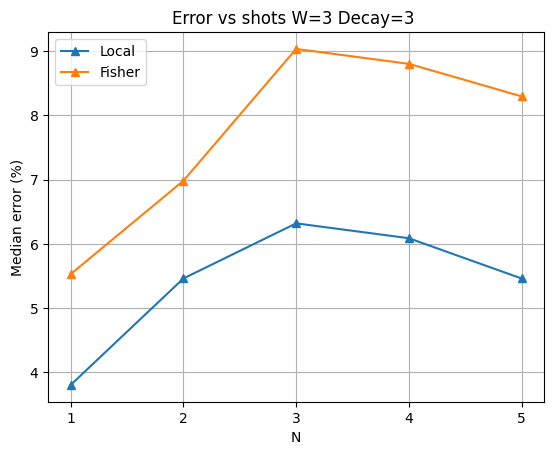

In [6]:
import matplotlib.pyplot as plt

# plt.plot(shots, errors_global_median, '-^', label='Global')
plt.plot(N, errors_local_median, '-^', label='Local')
plt.plot(N, errors_fisher_median, '-^', label='Fisher')
# plt.plot(shots, errors_uniform_median, '-^', label='Uniform')
# plt.errorbar(N, errors_fisher_median, yerr=errors_fisher_std, fmt='none', ecolor='red')
# plt.errorbar(N, errors_local_median, yerr=errors_local_std)

plt.title(f'Error vs shots W={W[0]} Decay={Decay[0]} ')
plt.xlabel('N')
plt.ylabel('Median error (%)')
plt.xticks(N)
plt.grid()
# plt.yscale('log')
# plt.xscale('log')

plt.legend()